In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import torch.nn as nn
import pathlib, copy
from functools import partial
import sys, glob
import numpy as np
from timm.models.fx_features import GraphExtractNet
from collections import OrderedDict

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from architectures.utils import intermediate_layer_names, FlattenNormalizeConcatenate
from attack.callbacks import AdvCallback
from datasets.data_modules import DATA_MODULES
import datasets.dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH

In [12]:
CHECKPOINT_PATHS = {
    'resnet50': {
#         'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'},
    'vit_small_patch16_224': {'nonrob': ''},
    'vit_small_patch32_224': {'nonrob': ''}
}

In [13]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNING_DATASETS = ['cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']
FINETUNE_MODE = 'random'
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 100

In [14]:
def calc_acc(dm, m1):
    pl_utils.seed.seed_everything(SEED, workers=True)

    trainer = Trainer(accelerator='gpu', 
                      devices=DEVICES,
                      num_nodes=NUM_NODES,
                      log_every_n_steps=1,
                      auto_select_gpus=True, 
                      deterministic=True,
                      check_val_every_n_epoch=1,
                      num_sanity_val_steps=0,
                      callbacks=[
                        LitProgressBar(['loss', 
                                        'running_test_acc'])])
    out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
    gt = out[1]
    pred = torch.argmax(out[0], 1)
    return torch.sum(gt == pred) / len(gt)

def get_seed_from_path(path):
    return int(path.split('-seed-')[1].split('-')[0])

def acc_over_seeds(base_model, finetuned_paths, mode, dm, finetuning_dataset, fraction, num_neurons):
    '''
    mode: "last" or "full"
    finetuned_paths: list of paths from where to load finetuned weights
    base_model: original pretrained model, instance of LightningModule
    '''
    accs = []
    og_model = copy.deepcopy(base_model.model)
    if mode == 'full':
        for path in finetuned_paths:
            sd_full = torch.load(path)
            base_model.model = copy.deepcopy(og_model)
            new_layer, num_fts, _, _ = ft.setup_model_for_finetuning(
                base_model.model,
                dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'], FINETUNE_MODE, 
                0.000001 if fraction is not None and fraction == 0. else fraction,
                # edge case where precision wasn't enough in saving filename
                get_seed_from_path(path), inplace=True, infer_features=True, 
                num_neurons=num_neurons, return_metadata=True)
            linear_layer = list(base_model.model.named_modules())[-1][1]
            linear_layer.load_state_dict({k.split('.')[-1]:v \
                                          for k,v in sd_full['state_dict'].items()}, strict=True)
            if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in sd_full:
                assert torch.all(new_layer.neuron_indices == sd_full['neuron_indices'])
            accs.append(calc_acc(dm, base_model))
    else:
        for path in finetuned_paths:
            sd_last = torch.load(path)
            base_model.model = copy.deepcopy(og_model)
            new_layer, num_fts, _, _ = ft.setup_model_for_finetuning(
                base_model.model, 
                dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
                FINETUNE_MODE, fraction, get_seed_from_path(path), inplace=True, 
                num_neurons=num_neurons, return_metadata=True)
            linear_layer = list(base_model.model.named_modules())[-1][1]
            linear_layer.load_state_dict({k.split('.')[-1]:v \
                                          for k,v in sd_last['state_dict'].items()}, strict=True)
            if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in sd_last:
                assert torch.all(new_layer.neuron_indices == sd_last['neuron_indices'])
            accs.append(calc_acc(dm, base_model))
    return accs, num_fts


def get_test_acc(model, source_dataset, append, finetuning_dataset, checkpoint_path, fraction):
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m_full = arch.create_model(model, source_dataset, pretrained=True,
                               checkpoint_path=checkpoint_path, seed=SEED, 
                               num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                               callback=partial(LightningWrapper, 
                                                dataset_name=source_dataset))
    layer_names = intermediate_layer_names(m_full.model)
    chopped_model = GraphExtractNet(m_full.model, layer_names)
    m_full.model = nn.Sequential(
        OrderedDict([
            ('feature_extractor', chopped_model), 
            ('flatten_normalize_concat', FlattenNormalizeConcatenate())
            ]))

    m_last = arch.create_model(model, source_dataset, pretrained=True,
                               checkpoint_path=checkpoint_path, seed=SEED, 
                               num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                               callback=partial(LightningWrapper, 
                                                dataset_name=source_dataset))
    
    last_layer_weights = [x for x in glob.glob(
        f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{finetuning_dataset}/'
        f'frac-{fraction:.5f}-mode-{FINETUNE_MODE}-seed-*-'
        f'ftmode-linear-lr-*-bs*-{append}/'
        '*-topk=1.ckpt') if 'full-feature' not in x and \
                            'layer' not in x and \
                            'pool' not in x]
    last_accs, num_fts = acc_over_seeds(m_last, last_layer_weights, 'last', dm, finetuning_dataset,
                                        fraction=fraction, num_neurons=None)
    
    _,_,_, frac_all = ft.setup_model_for_finetuning(m_full.model, 
                                  num_classes=1, 
                                  mode=FINETUNE_MODE, 
                                  fraction=None, 
                                  seed=1, 
                                  inplace=False,
                                  infer_features=True,
                                  num_neurons=int(num_fts * fraction), 
                                  return_metadata=True)
    print (f'Fraction for full feature: {frac_all:.8f}')
    full_feature_weights = glob.glob(f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{finetuning_dataset}/'
                                           f'frac-{frac_all:.8f}-mode-{FINETUNE_MODE}-seed-*-'
                                           f'ftmode-linear-lr-*-bs*-{append}/'
                                           '*-full-feature-topk=1.ckpt')
    if len(full_feature_weights) > 0:
        full_accs, _ = acc_over_seeds(m_full, full_feature_weights, 'full', dm, finetuning_dataset,
                                      fraction=None, num_neurons=int(num_fts * fraction))
    else:
        full_accs = [np.nan]
    
    return last_accs, full_accs, num_fts

In [15]:
def results_same_number(model, source_dataset):
    plt_str = '== Finetuning results ==\n\n'
    for append in CHECKPOINT_PATHS[model].keys():
        plt_str += f'=== {model} - {append} ===\n\n'
        for ft_ds in FINETUNING_DATASETS[:3]:
            plt_str += f'==== {ft_ds} ====\n\n'
            frac_wise_test_accs_last, frac_wise_test_accs_full = {}, {}
            PARTIAL_FRACTIONS_FULL_LAYER = sorted(
                list(set(
                    [float(x.split('/frac-')[1].split('-')[0]) for x in \
                        glob.glob(f'./checkpoints/{model}-base-'
                                  f'{source_dataset}-ft-{ft_ds}/'
                                  f'*-bs-256-{append}/*') \
                     if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                     'full-feature' not in x.split('/')[-1] and \
                     'layer' not in x.split('/')[-1] and \
                     'pool' not in x.split('/')[-1]]
                    )))
            for frac in PARTIAL_FRACTIONS_FULL_LAYER:
                last_layer_accs, all_fts_accs, num_fts_final_layer = get_test_acc(
                    model, source_dataset, append, ft_ds, CHECKPOINT_PATHS[model][append], frac)
                print (f'{model} {append} {frac} {ft_ds}, '
                       f'last layer: {np.mean(last_layer_accs)}, full: {np.mean(all_fts_accs)}')
                frac_wise_test_accs_last[frac] = last_layer_accs
                frac_wise_test_accs_full[frac] = all_fts_accs

            x_last, y_last = list(zip(*sorted(frac_wise_test_accs_last.items(), key=lambda t: t[0])))
            _, y_full = list(zip(*sorted(frac_wise_test_accs_full.items(), key=lambda t: t[0])))
            x_vals = [int(x*num_fts_final_layer) for x in x_last]
            plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(plt_hp.line_plot(
                [[np.nanmean(_y) for _y in y_last], [np.nanmean(_y) for _y in y_full]], 
                'Number of Neurons', 'Transfer Accuracy', ft_ds, 
                subfolder=source_dataset, filename=f'{model}_{ft_ds}_bs_{FINETUNE_BS}_{append}_samenumber', 
                extension='png', x_vals=x_vals, 
                legend_vals=['Last Layer', 'Using Full Features'], 
                vertical_line=None, horizontal_lines=None, 
                horizontal_lines_err=None, colors=plt_hp.COLORS, 
                linestyles=['-', '-'], y_lims=(0.,1.), root_dir='.', 
                paper_friendly_plots=False, plot_inside=False, legend_location='best', 
                savefig=True, figsize=(10,6), marker=[True, True], 
                results_subfolder_name='full_feature_analysis', grid_spacing=None, 
                y_err=[[np.nanstd(_y) for _y in y_last], [np.nanstd(_y) for _y in y_full]], 
                legend_ncol=None), SERVER_PROJECT_PATH, size=700))
    with open(f'./results/full_feature_analysis/{source_dataset}/'
              f'wiki_results-{model}-same-number.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'full_feature_analysis', source_dataset)], 
        'results', SERVER_PROJECT_PATH, '.png')

Global seed set to 2
Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000018
resnet50 robustl2eps3 0.0005 cifar10, last layer: 0.13144001364707947, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000036
resnet50 robustl2eps3 0.001 cifar10, last layer: 0.1569800078868866, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000072
resnet50 robustl2eps3 0.002 cifar10, last layer: 0.22224000096321106, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000109
resnet50 robustl2eps3 0.003 cifar10, last layer: 0.2547599971294403, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000145
resnet50 robustl2eps3 0.004 cifar10, last layer: 0.2949399948120117, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000181
resnet50 robustl2eps3 0.005 cifar10, last layer: 0.32829999923706055, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00000362


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.01 cifar10, last layer: 0.4647800028324127, full: 0.20810000598430634


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00001847


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.05 cifar10, last layer: 0.7464799880981445, full: 0.33841997385025024


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00003695


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.1 cifar10, last layer: 0.8065800070762634, full: 0.39984002709388733


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00007408


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.2 cifar10, last layer: 0.8412401080131531, full: 0.4599999785423279


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00011120


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.3 cifar10, last layer: 0.8542900085449219, full: 0.4976000189781189


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00018546


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.5 cifar10, last layer: 0.8674600720405579, full: 0.5407199859619141


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00029666


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.8 cifar10, last layer: 0.8755200505256653, full: 0.5840799808502197


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00033379


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.9 cifar10, last layer: 0.8769399523735046, full: 0.5963999629020691


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00037092


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

resnet50 robustl2eps3 1.0 cifar10, last layer: 0.8769999742507935, full: 0.6043000221252441


/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


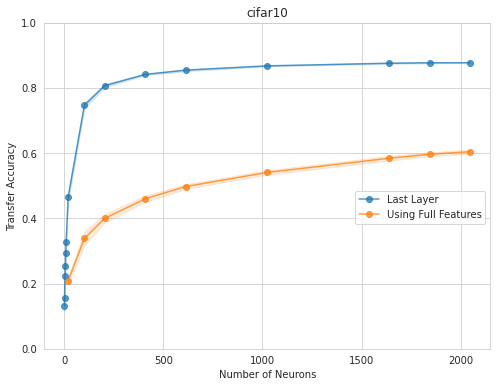

Global seed set to 2
Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000018
resnet50 robustl2eps3 0.0005 cifar100, last layer: 0.01802000030875206, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000036
resnet50 robustl2eps3 0.001 cifar100, last layer: 0.026899999007582664, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000072
resnet50 robustl2eps3 0.002 cifar100, last layer: 0.04466000199317932, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000109
resnet50 robustl2eps3 0.003 cifar100, last layer: 0.06223999708890915, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000145
resnet50 robustl2eps3 0.004 cifar100, last layer: 0.07782500237226486, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000181
resnet50 robustl2eps3 0.005 cifar100, last layer: 0.09689999371767044, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00000362


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.01 cifar100, last layer: 0.19107501208782196, full: 0.02744000032544136


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00001847


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.05 cifar100, last layer: 0.4841749966144562, full: 0.08051999658346176


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00003695


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.1 cifar100, last layer: 0.5728344917297363, full: 0.10286001116037369


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00007408


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.2 cifar100, last layer: 0.6242428421974182, full: 0.13729999959468842


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00011120


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.3 cifar100, last layer: 0.645614743232727, full: 0.16208000481128693


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00018546


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.5 cifar100, last layer: 0.6609750390052795, full: 0.19728000462055206


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00029666


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.8 cifar100, last layer: 0.671000063419342, full: 0.23542001843452454


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00033379


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


resnet50 robustl2eps3 0.9 cifar100, last layer: 0.6744999885559082, full: 0.24667999148368835


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Fraction for full feature: 0.00037092


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

resnet50 robustl2eps3 1.0 cifar100, last layer: 0.67330002784729, full: 0.25450000166893005


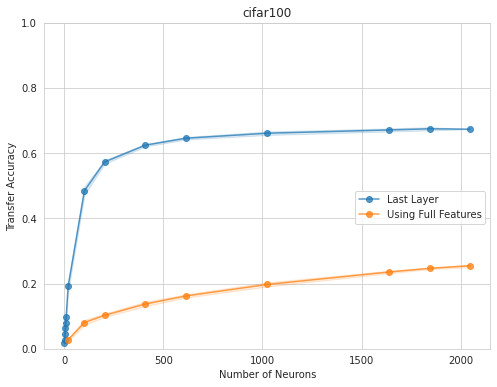

Global seed set to 2
Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000018
resnet50 robustl2eps3 0.0005 flowers, last layer: 0.022995609790086746, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000036
resnet50 robustl2eps3 0.001 flowers, last layer: 0.009269800037145615, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


Fraction for full feature: 0.00000072
resnet50 robustl2eps3 0.002 flowers, last layer: 0.009074646048247814, full: nan


Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

In [ ]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50'
results_same_number(MODEL, SOURCE_DATASET)